## Tax Risk

In [1]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

import pandas as pd
import numpy as np

/Users/torayeff/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Embedding
max_features = 100
maxlen = 100
embedding_size = 32

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 1

In [3]:
train_df = pd.read_csv('private/sorted_train.csv')
test_df = pd.read_csv('private/sorted_test.csv')

In [4]:
tok = Tokenizer(num_words=max_features, split=' ')
tok.fit_on_texts(train_df['text'].values)
X_train = tok.texts_to_sequences(train_df['text'].values)
Y_train = pd.get_dummies(train_df['dummy1']).values

X_test = tok.texts_to_sequences(test_df['text'].values)
Y_test = pd.get_dummies(test_df['dummy1']).values

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

### Build a model

In [5]:
model = Sequential()
model.add(Embedding(max_features, embedding_size, 
                    input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print("Model summary: ")
print(model.summary())

print('Train...')
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs)

score, acc = model.evaluate(X_train, Y_train, batch_size=batch_size)
print("Score on train set: ", score)
print("Accuracy on train set: ", acc)

score, acc = model.evaluate(X_test, Y_test, batch_size=batch_size)
print("Score on test set: ", score)
print("Accuracy on test set: ", acc)

Model summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           3200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 142       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0    

In [6]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred > 0.5).astype(int)

In [7]:
tp = 0
tn = 0
fp = 0
fn = 0

# [0, 1] positive, i.e, tax risk exists
# [1, 0] negative, no tax risk
for i in range(len(Y_test)):
    # positive
    if np.argmax(Y_test[i]) == 1:
        # positive
        if np.argmax(Y_pred[i]) == 1:
            tp += 1
        # negative
        else:
            fn += 1
    # negative        
    else:
        # negative
        if np.argmax(Y_pred[i] == 0):
            tn +=1
        # positive
        else:
            fp += 1
print("True positive: ", tp)
print("False positive: ", fp)
print("True negative: ", tn)
print("False negative: ", fn)
cm = [
    [tn, fp],
    [fn, tp]
]
precision = tp/(tp + fp)
recall = tp/(tp + fn)
f1_score = 2 * precision * recall / (precision + recall)
accuracy = (tp + tn) / (tp + tn + fp + fn)
print("Precision: %.4lf"%precision)
print("Recall: %.4lf"%recall)
print("F1-score: %.4lf"%f1_score)
print("Accuracy: %.4lf"%accuracy)

True positive:  1502
False positive:  1020
True negative:  4134
False negative:  92
Precision: 0.5956
Recall: 0.9423
F1-score: 0.7298
Accuracy: 0.8352


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(cm, classes):
    """Plot confusion matrix from metrics.confusion_matrix numpy.ndarray
    
    Args:
        cm: numpy.ndarray confusion matrix which is returned from metrics.confusion matrix
        classes: list of class names
    """
    if len(classes) == 2:
        # the count of true negatives is C_{0,0}, 
        # false negatives is C_{1,0}, 
        # true positives is C_{1,1}, 
        # false positives is C_{0,1}.
        classes = [classes[0]+": (- class)", classes[1]+": (+ class)"]
        
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    fig = plt.figure()
    heatmap = sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels())
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels())
    plt.xlabel("PREDICTED LABEL")
    plt.ylabel("TRUE LABEL")

def get_scores(cm):
    """Return precision, recall, accuracy, f1-score from confusion matrix.
       the count of true negatives is cm[0,0]
       the count of false negatives is cm[1, 0]
       the count of true positives is cm[1, 1]
       the count of false positives is cm[0, 1]
    
    Args:
        cm: numpy.ndarray confusion matrix which is returned from metrics.confusion matrix
    
    Returns:
        scores: dictionary of scores
    """
    tn, fp, fn, tp = cm.ravel()
    
    scores = {}
    scores['precision'] = tp/(tp + fp)
    scores['recall'] = tp/(tp + fn)
    scores['accuracy'] = (tp + tn)/(tp + tn + fp + fn)
    scores['f1'] = 2*scores['precision']*scores['recall']/(scores['precision'] + scores['recall'])
    
    return scores    

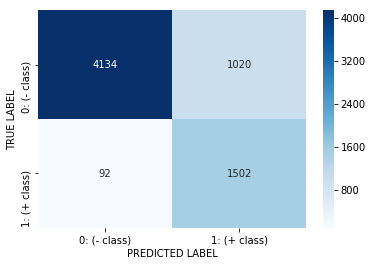

In [9]:
plot_confusion_matrix(cm, ['0', '1'])